In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
! unzip '/content/drive/MyDrive/real-vs-fake.zip'

Archive:  /content/drive/MyDrive/real-vs-fake.zip
replace real-vs-fake/test/fake/001DDU0NI4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install pytorch-ignite

In [ ]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

#from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
#import ignite.metrics
#import ignite.contrib.handlers
#from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
DATA_DIR='/content/real-vs-fake/'

IMAGE_SIZE = 128

NUM_CLASSES = 2
NUM_WORKERS = 4
BATCH_SIZE = 32
EPOCHS = 200

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [ ]:
import os
root_dir = "/content/real-vs-fake"
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'test':transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor()
      
    ])
}

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(root_dir, 'train'), data_transforms['train'])
image_datasets['test'] = datasets.ImageFolder(os.path.join(root_dir, 'test'), data_transforms['test'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(root_dir, 'valid'), data_transforms['test'])


In [ ]:
batch_size = BATCH_SIZE
data_loader = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True) for x in ['train','val','test']}
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val','test']}
print(dataset_sizes)

{'train': 25000, 'val': 5000, 'test': 5000}


In [ ]:
class_names = image_datasets['test'].classes
print(class_names)
_ = image_datasets['test'].class_to_idx
cat_to_name = {_[i]:i for i in list(_.keys())}
print(cat_to_name)

images, labels = next(iter(data_loader['train']))
print(images.size())

['fake', 'real']
{0: 'fake', 1: 'real'}
torch.Size([32, 3, 128, 128])


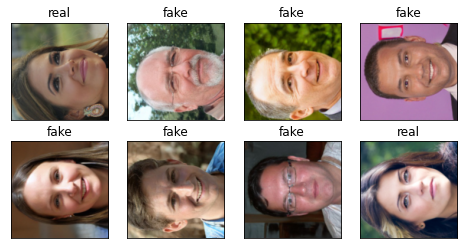

In [ ]:
def showimage(data_loader, number_images, cat_to_name):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(number_images, 4))
    for idx in np.arange(number_images):
        ax = fig.add_subplot(2, number_images//2, idx+1, xticks=[], yticks=[])
        img = np.transpose(images[idx])
        plt.imshow(img)
        ax.set_title(cat_to_name[labels.tolist()[idx]])
        
#### to show some  images
showimage(data_loader['test'], 8, cat_to_name)

In [ ]:
"""
train_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
"""


In [ ]:
"""
test_transform = transforms.Compose([ 
    transforms.Resize(256), 
    transforms.CenterCrop(224),                                                             
    transforms.ToTensor()
])
"""

In [ ]:
"""
import torchvision
#train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
#test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())
train_dset = torchvision.datasets.ImageFolder('/content/real-vs-fake/train/', transform=train_transform)
test_dset = torchvision.datasets.ImageFolder('/content/real-vs-fake/test/',  transform=test_transform)
"""

"\nimport torchvision\n#train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)\n#test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())\ntrain_dset = torchvision.datasets.ImageFolder('/content/real-vs-fake/train/', transform=train_transform)\ntest_dset = torchvision.datasets.ImageFolder('/content/real-vs-fake/test/',  transform=test_transform)\n"

In [ ]:
#print(test_dset[0][0].shape)

In [ ]:
#print(train_dset[0][0].shape)

In [ ]:
#print(len(train_dset))

In [ ]:
#print(len(test_dset))

In [ ]:
"""
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()
"""

In [ ]:
#dataset_show_image(test_dset, 1)

In [ ]:
#train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
#                                           num_workers=NUM_WORKERS, pin_memory=True)
#test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
#                                          num_workers=NUM_WORKERS, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Model**

In [ ]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return x + self.gamma * self.residual(x)

In [ ]:
class GlobalAvgPool(nn.Module):
    def forward(self, x):
        return x.mean(dim=-2)

In [ ]:
class ShiftedWindowAttention(nn.Module):
    def __init__(self, dim, head_dim, shape, window_size, shift_size=0):
        super().__init__()
        self.heads = dim // head_dim
        self.head_dim = head_dim
        self.scale = head_dim**-0.5
        
        self.shape = shape
        self.window_size = window_size
        self.shift_size = shift_size
        
        self.to_qkv = nn.Linear(dim, dim * 3)
        self.unifyheads = nn.Linear(dim, dim)
        
        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * window_size - 1)**2))
        self.register_buffer("relative_indices", self.get_indices(window_size))
        
        if shift_size > 0:
            self.register_buffer("mask", self.generate_mask(shape, window_size, shift_size))
    
    
    def forward(self, x):
        shift_size, window_size = self.shift_size, self.window_size
        
        x = self.to_windows(x, self.shape, window_size, shift_size) # partition into windows
        
        # self attention
        qkv = self.to_qkv(x).unflatten(-1, (3, self.heads, self.head_dim)).transpose(-2, 1)
        queries, keys, values = qkv.unbind(dim=2)
        
        att = queries @ keys.transpose(-2, -1)
        
        att = att * self.scale + self.get_rel_pos_enc(window_size) # add relative positon encoding
        
        # masking
        if shift_size > 0:
            att = self.mask_attention(att)
        
        att = F.softmax(att, dim=-1)
        
        x = att @ values
        x = x.transpose(1, 2).contiguous().flatten(-2, -1) # move head back
        x = self.unifyheads(x)
        
        x = self.from_windows(x, self.shape, window_size, shift_size) # undo partitioning into windows
        return x
    
    
    def to_windows(self, x, shape, window_size, shift_size):
        x = x.unflatten(1, shape)
        if shift_size > 0:
            x = x.roll((-shift_size, -shift_size), dims=(1, 2))
        x = self.split_windows(x, window_size)
        return x
    
    
    def from_windows(self, x, shape, window_size, shift_size):
        x = self.merge_windows(x, shape, window_size) 
        if shift_size > 0:
            x = x.roll((shift_size, shift_size), dims=(1, 2))
        x = x.flatten(1, 2)
        return x
    
    
    def mask_attention(self, att):
        num_win = self.mask.size(1)
        att = att.unflatten(0, (att.size(0) // num_win, num_win))
        att = att.masked_fill(self.mask, float('-inf'))
        att = att.flatten(0, 1)
        return att
    
    
    def get_rel_pos_enc(self, window_size):
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (window_size**2, window_size**2))
        return rel_pos_enc
    
    
    # For explanation of mask regions see Figure 4 in the article
    @staticmethod
    def generate_mask(shape, window_size, shift_size):
        region_mask = torch.zeros(1, *shape, 1)
        slices = [slice(0, -window_size), slice(-window_size, -shift_size), slice(-shift_size, None)]
        
        region_num = 0
        for i in slices:
            for j in slices:
                region_mask[:, i, j, :] = region_num
                region_num += 1

        mask_windows = ShiftedWindowAttention.split_windows(region_mask, window_size).squeeze(-1)
        diff_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        mask = diff_mask != 0
        mask = mask.unsqueeze(1).unsqueeze(0) # add heads and batch dimension
        return mask
    
    
    @staticmethod
    def split_windows(x, window_size):
        n_h, n_w = x.size(1) // window_size, x.size(2) // window_size
        x = x.unflatten(1, (n_h, window_size)).unflatten(-2, (n_w, window_size)) # split into windows
        x = x.transpose(2, 3).flatten(0, 2) # merge batch and window numbers
        x = x.flatten(-3, -2)
        return x
    
    
    @staticmethod
    def merge_windows(x, shape, window_size):
        n_h, n_w = shape[0] // window_size, shape[1] // window_size
        b = x.size(0) // (n_h * n_w)
        x = x.unflatten(1, (window_size, window_size))
        x = x.unflatten(0, (b, n_h, n_w)).transpose(2, 3) # separate batch and window numbers
        x = x.flatten(1, 2).flatten(-3, -2) # merge windows
        return x
    
    
    @staticmethod
    def get_indices(window_size):
        x = torch.arange(window_size, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(x, x, x, x, indexing='ij')
        indices = (y1 - y2 + window_size - 1) * (2 * window_size - 1) + x1 - x2 + window_size - 1
        indices = indices.flatten()
        
        return indices

In [ ]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, mult=4):
        hidden_dim = dim * mult
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)   
        )

In [ ]:
class TransformerBlock(nn.Sequential):
    def __init__(self, dim, head_dim, shape, window_size, shift_size=0, p_drop=0.):
        super().__init__(
            Residual(
                nn.LayerNorm(dim),
                ShiftedWindowAttention(dim, head_dim, shape, window_size, shift_size),
                nn.Dropout(p_drop)
            ),
            Residual(
                nn.LayerNorm(dim),
                FeedForward(dim),
                nn.Dropout(p_drop)
            )
        )

In [ ]:
class PatchMerging(nn.Module):
    def __init__(self, in_dim, out_dim, shape):
        super().__init__()
        self.shape = shape
        self.norm = nn.LayerNorm(4 * in_dim)
        self.reduction = nn.Linear(4 * in_dim, out_dim, bias=False)
    
    def forward(self, x):
        x = x.unflatten(1, self.shape).movedim(-1, 1)
        x = F.unfold(x, kernel_size=2, stride=2).movedim(1, -1)
        
        x = self.norm(x)
        x = self.reduction(x)
        return x

In [ ]:
class Stage(nn.Sequential):
    def __init__(self, num_blocks, in_dim, out_dim, head_dim, shape, window_size, p_drop=0.):
        if out_dim != in_dim:
            layers = [PatchMerging(in_dim, out_dim, shape)]
            shape = (shape[0] // 2, shape[1] // 2)
        else:
            layers = []
        
        shift_size = window_size // 2
        layers += [TransformerBlock(out_dim, head_dim, shape, window_size, 0 if (num % 2 == 0) else shift_size,
                                    p_drop) for num in range(num_blocks)]
        
        super().__init__(*layers)

In [ ]:
class StageStack(nn.Sequential):
    def __init__(self, num_blocks_list, dims, head_dim, shape, window_size, p_drop=0.):
        layers = []
        in_dim = dims[0]
        for num, out_dim in zip(num_blocks_list, dims[1:]):
            layers.append(Stage(num, in_dim, out_dim, head_dim, shape, window_size, p_drop))
            if in_dim != out_dim:
                shape = (shape[0] // 2, shape[1] // 2)
                in_dim = out_dim
        
        super().__init__(*layers)

In [ ]:
class ToPatches(nn.Module):
    def __init__(self, in_channels, dim, patch_size):
        super().__init__()
        self.patch_size = patch_size
        patch_dim = in_channels * patch_size**2
        self.proj = nn.Linear(patch_dim, dim)
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x):
        x = F.unfold(x, kernel_size=self.patch_size, stride=self.patch_size).movedim(1, -1)
        x = self.proj(x)
        x = self.norm(x)
        return x

In [ ]:
class AddPositionEmbedding(nn.Module):
    def __init__(self, dim, num_patches):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.Tensor(num_patches, dim))
    
    def forward(self, x):
        return x + self.pos_embedding

In [ ]:
class ToEmbedding(nn.Sequential):
    def __init__(self, in_channels, dim, patch_size, num_patches, p_drop=0.):
        super().__init__(
            ToPatches(in_channels, dim, patch_size),
            AddPositionEmbedding(dim, num_patches),
            nn.Dropout(p_drop)
        )

In [ ]:
class Head(nn.Sequential):
    def __init__(self, dim, classes, p_drop=0.):
        super().__init__(
            nn.LayerNorm(dim),
            nn.GELU(),
            GlobalAvgPool(),
            nn.Dropout(p_drop),
            nn.Linear(dim, classes)
        )

In [ ]:
class SwinTransformer(nn.Sequential):
    def __init__(self, classes, image_size, num_blocks_list, dims, head_dim, patch_size, window_size,
                 in_channels=3, emb_p_drop=0., trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // patch_size
        shape = (reduced_size, reduced_size)
        num_patches = shape[0] * shape[1]
        
        super().__init__(
            ToEmbedding(in_channels, dims[0], patch_size, num_patches, emb_p_drop),
            StageStack(num_blocks_list, dims, head_dim, shape, window_size, trans_p_drop),
            Head(dims[-1], classes, head_p_drop)
        )
        self.reset_parameters()
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, AddPositionEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            elif isinstance(m, ShiftedWindowAttention):
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)
    
    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, )
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, AddPositionEmbedding) and param_name.endswith("pos_embedding"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, ShiftedWindowAttention) and param_name.endswith("pos_enc"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        # sanity check
        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

        return parameters_decay, parameters_no_decay

In [ ]:
model = SwinTransformer(NUM_CLASSES, IMAGE_SIZE,
                        num_blocks_list=[4, 4], dims=[128, 128, 256],
                        head_dim=128, patch_size=4, window_size=8,
                        emb_p_drop=0., trans_p_drop=0., head_p_drop=0.3)

In [ ]:
print(EPOCHS)

200


In [ ]:
print(IMAGE_SIZE)

128


In [ ]:
model.to(DEVICE);

In [ ]:

from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max)) 

In [ ]:

import time
import math
import copy
model_acc = []
model_loss = []
model_val_acc = []
model_val_loss = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, path='model.pth'):
   
    start = time.time()
    pb_train = display(progress(0, num_epochs), display_id=True)
    pb_phase = display(progress(0, 10), display_id=True)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.
    
    for epoch in range(num_epochs):
        pb_train.update(progress(epoch+1, num_epochs))
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                pb_phase.update(progress(i+1, len(data_loader[phase])))
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                
                optimizer.zero_grad()
                if i%1000==999:
                    print(f"[{epoch+1}, {i} loss: {running_loss/(i*inputs.size(0)):.4f}]")
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects/dataset_sizes[phase]    
            if phase=='train':
                scheduler.step()
                model_acc.append(epoch_acc)
                model_loss.append(epoch_loss)
            if phase=='val':
               model_val_acc.append(epoch_acc)
               model_val_loss.append(epoch_loss)   
            
            
            
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase=='val' and epoch_acc>best_acc:
                print(f'New acc: {epoch_acc:.4f}, previous acc: {best_acc:.4f}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_loss': best_loss,
                            'best_val_accuracy': best_acc,
                            'scheduler_state_dict' : scheduler.state_dict(),
                            }, path)
                print(f'New model is SAVED')
                print()
    time_elapsed = time.time()-start
    print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))
    
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc
   

In [ ]:

for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(data_loader['train']), epochs=EPOCHS)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("The number of parameters of the model: ", count_params(model))


The number of parameters of the model:  4225566


In [53]:

model, best_val_loss, best_val_acc = train_model(model,
                                                 criterion,
                                                 optimizer,
                                                 lr_scheduler,
                                                 num_epochs = EPOCHS)


Epoch 1/200
train loss: 0.7361 acc: 0.5027
val loss: 0.6911 acc: 0.5150
New acc: 0.5150, previous acc: 0.0000
New model is SAVED

Epoch 2/200
train loss: 0.7069 acc: 0.5088
val loss: 0.6925 acc: 0.5030
Epoch 3/200
train loss: 0.7004 acc: 0.5150
val loss: 0.6909 acc: 0.5384
New acc: 0.5384, previous acc: 0.5150
New model is SAVED

Epoch 4/200
train loss: 0.7002 acc: 0.5112
val loss: 0.6903 acc: 0.5312
Epoch 5/200
train loss: 0.6967 acc: 0.5153
val loss: 0.6907 acc: 0.5304
Epoch 6/200
train loss: 0.6950 acc: 0.5152
val loss: 0.6903 acc: 0.5180
Epoch 7/200
train loss: 0.6954 acc: 0.5131
val loss: 0.6903 acc: 0.5208
Epoch 8/200
train loss: 0.6936 acc: 0.5199
val loss: 0.6908 acc: 0.5070
Epoch 9/200
train loss: 0.6927 acc: 0.5220
val loss: 0.6897 acc: 0.5446
New acc: 0.5446, previous acc: 0.5384
New model is SAVED

Epoch 10/200
train loss: 0.6918 acc: 0.5256
val loss: 0.6898 acc: 0.5576
New acc: 0.5576, previous acc: 0.5446
New model is SAVED

Epoch 11/200
train loss: 0.6926 acc: 0.5201
val

train loss: 0.3800 acc: 0.8320
val loss: 0.4151 acc: 0.8132


Epoch 149/200
train loss: 0.3770 acc: 0.8341
val loss: 0.4027 acc: 0.8154
Epoch 150/200
train loss: 0.3765 acc: 0.8332
val loss: 0.3975 acc: 0.8150
Epoch 151/200
train loss: 0.3711 acc: 0.8347
val loss: 0.3918 acc: 0.8194
Epoch 152/200
train loss: 0.3667 acc: 0.8406
val loss: 0.4012 acc: 0.8176
Epoch 153/200
train loss: 0.3661 acc: 0.8372
val loss: 0.3867 acc: 0.8260
New acc: 0.8260, previous acc: 0.8196
New model is SAVED

Epoch 154/200
train loss: 0.3660 acc: 0.8415
val loss: 0.3828 acc: 0.8298
New acc: 0.8298, previous acc: 0.8260
New model is SAVED

Epoch 155/200
train loss: 0.3621 acc: 0.8424
val loss: 0.3817 acc: 0.8314
New acc: 0.8314, previous acc: 0.8298
New model is SAVED

Epoch 156/200
train loss: 0.3598 acc: 0.8421
val loss: 0.3844 acc: 0.8258
Epoch 157/200
train loss: 0.3538 acc: 0.8451
val loss: 0.3800 acc: 0.8260
Epoch 158/200
train loss: 0.3539 acc: 0.8449
val loss: 0.3874 acc: 0.8240
Epoch 159/200
train loss: 0.3510 acc: 0.8478
val loss: 0.3745 acc: 0.8286
Epoch 160/20

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    plt.show()

In [57]:
checkpoint = torch.load('model.pth')
def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model('model.pth')  
model = model.to(DEVICE)

Testing complete in 0m 9s
              precision    recall  f1-score   support

           0     0.8898    0.8788    0.8843      2500
           1     0.8803    0.8912    0.8857      2500

    accuracy                         0.8850      5000
   macro avg     0.8851    0.8850    0.8850      5000
weighted avg     0.8851    0.8850    0.8850      5000



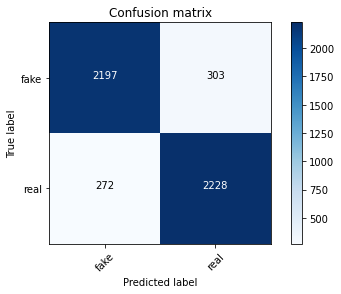

In [58]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import itertools
since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['test']:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
time_elapsed = time.time() - since

print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

confusion_mtx = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plot_labels = ['fake', 'real']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_test, y_pred, digits=4)
print(report)

Area under the Receiver Operating Characteristic curve: 0.885


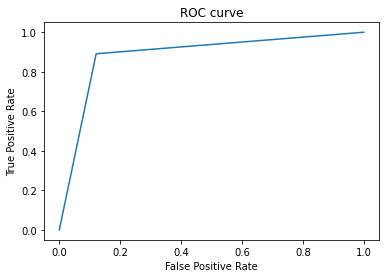

In [85]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_test, y_pred))

In [59]:
len(model_loss)

200

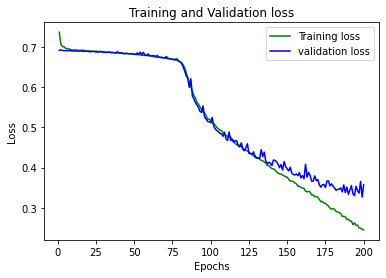

In [60]:
epochs = range(1,len(model_loss)+1)
plt.plot(epochs, model_loss, 'g', label='Training loss')
plt.plot(epochs, model_val_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

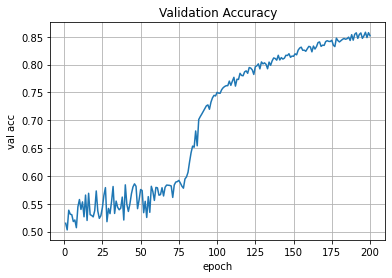

In [77]:
val_acc = [tensor.item() for tensor in model_val_acc]
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(model_val_acc) + 1)
plt.title('Validation Accuracy')
ax.plot(xs, val_acc, '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()
